# Dec 24th, 2021 (ROI layers: compare)

**Motivation**: Compare

- **Old approach**: chuncks with equal thickness, with
- **New approach**: depth 1 = layers 1 + 2/3 + 4; depth 2 = layer 5; depth 3 = layers 6a + 6b <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((64, 0, 100), load_parcel=True, full_load=True, load_allen=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

## Plot dorsal flatmap and topview

In [3]:
# HIDE CODE


from register.atlas import Allen

# cortical map parcel flatt & top
al10 = Allen(10, full_load=False)
template = al10.mcc.get_template_volume()[0]

top = al10.cortical_map(template, proj='top_view', agg_func=np.max)
flatmap = al10.cortical_map(template, proj='dorsal_flatmap', agg_func=np.max)

# load parcel flatt & top
parcel_flat = 'parcel2d-flat_10um.nii.gz'
parcel_flat = pjoin(mice.cfg.parcel_dir, parcel_flat)
parcel_flat = ants.image_read(parcel_flat).numpy()

parcel_top = 'parcel2d-top_10um.nii.gz'
parcel_top = pjoin(mice.cfg.parcel_dir, parcel_top)
parcel_top = ants.image_read(parcel_top).numpy()

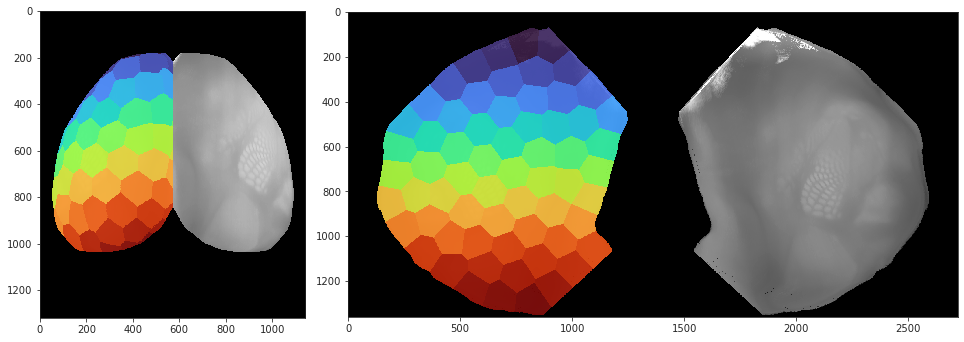

In [4]:
# HIDE CODE


fig, axes = create_figure(1, 2, (13.5, 7), gridspec_kw={'width_ratios': [1, 2.3]})
axes[0].imshow(top, cmap='Greys_r')
x2plt = np.ma.masked_where(~np.isin(parcel_top, range(1, mice.cfg.nn + 1)), parcel_top)
axes[0].imshow(x2plt, alpha=0.9, cmap='turbo')

axes[1].imshow(flatmap, cmap='Greys_r')
x2plt = np.ma.masked_where(~np.isin(parcel_flat, range(1, mice.cfg.nn + 1)), parcel_flat)
axes[1].imshow(x2plt, alpha=0.9, cmap='turbo')
plt.show()

K-means is applied to pixel coordinates in dorsal flatmap (right) to parcellate the cortical surface into spatially homogeneous, roughly equal sized parcels.  A more advanced tessellation algorithm could be used instead to tile the plane using one or more geometric shapes in a way that respects the local curvature.  However, given relatively smooth cortex in mouse brain this might be overkill for now.

On the left we see the same ROIs projected on the top view.  Each ROI here represents a column.  In the next sectoin I show how to add the depth dimension to these ROIs.

## Comparison (figs at $100 \mu m$ resolution)

In this section I visualize the following:

1. 6 layer laminar organization of the cortex (layer masks from Allen)
2. A coarse 3-depth system: depth-1 = layers 1 + 2/3 + 4; depth-2 = layer 5; and depth-3 = layers 6a + 6b.
3. The way I was previously dividing each column into layers: equal sized chunks.

In [5]:
# HIDE CODE


layer_mask_coarse, layer_mask = mice.al.make_layer_mask()

layer_mask_3 = sum(
    e.astype('int32') * i for i, e in
    enumerate(layer_mask_coarse.values(), start=1)
)

mice4 = Mice((192, 4, 100), load_parcel=True)

regions4 = mice4.parcel['cortex'][mice4.parcel['cortex'].nonzero()]
regions4 = np.unique(regions4)

hcl = mice4.parcel.decode(regions4)

layer_mask_4 = {
    f'layer-{ll}': np.isin(mice4.parcel['cortex'], mice4.parcel.encode(hcl[hcl[:, -1] == ll]))
    for ll in range(mice4.cfg.ll)
}
layer_mask_4 = sum(
    e.astype('int32') * i for i, e in
    enumerate(layer_mask_4.values(), start=1)
)

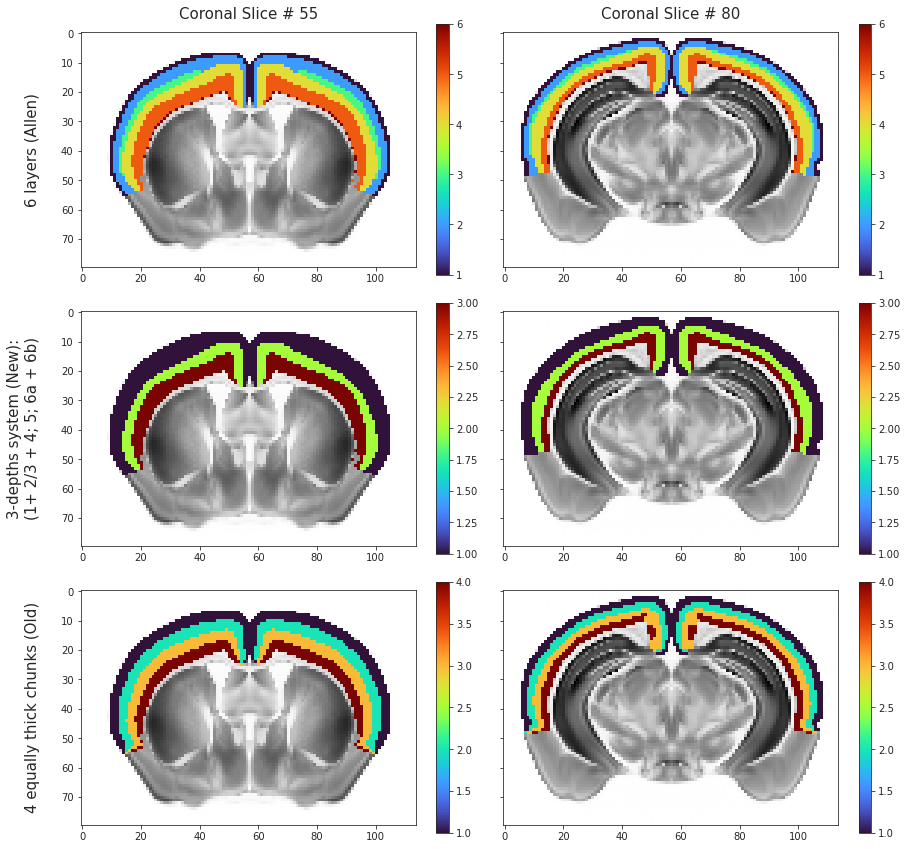

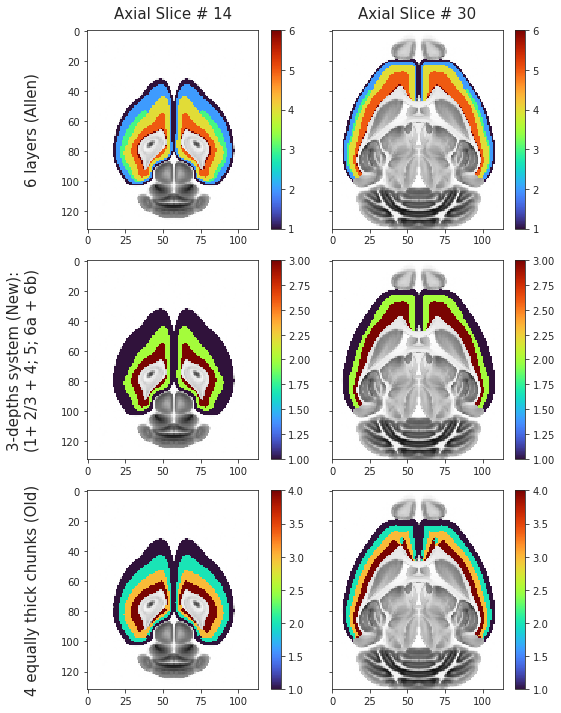

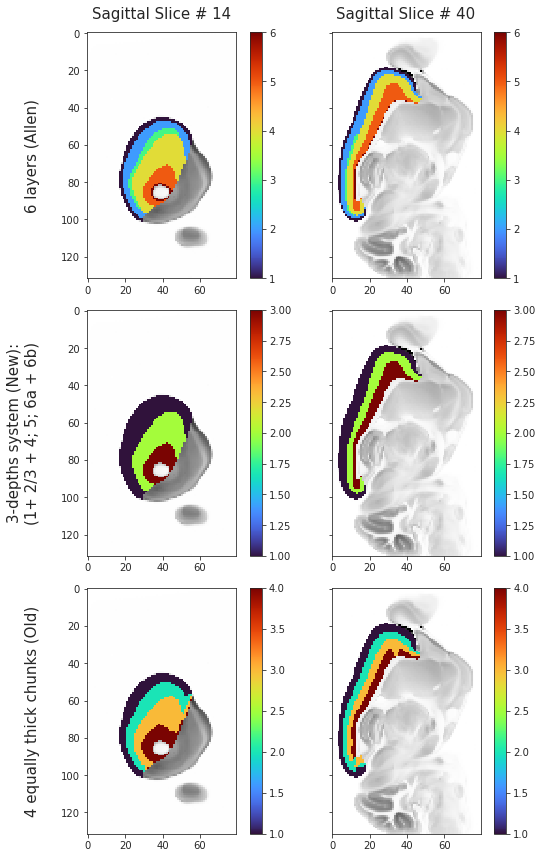

In [6]:
# HIDE CODE

cmap = 'turbo'
# root = mice.al.get_masks('root')
fig, axes = create_figure(3, 2, (13.0, 12), 'row', 'row')

for i, slice_i in enumerate([55, 80]): 
    data2plt = {
        '6 layers (Allen)': layer_mask[slice_i],
        '3-depths system (New):\n(1+ 2/3 + 4; 5; 6a + 6b)': layer_mask_3[slice_i],
        '4 equally thick chunks (Old)': layer_mask_4[slice_i],
    }
    for j, (lbl, item) in enumerate(data2plt.items()):
        axes[j, i].imshow(mice.al.template[slice_i], cmap='Greys')
        x2plt = np.ma.masked_where(~item.astype(bool), item)
        im = axes[j, i].imshow(x2plt, cmap=cmap)
        plt.colorbar(im, ax=axes[j, i])
        if i == 0:
            axes[j, i].set_ylabel(f"{lbl}\n", fontsize=15)
    axes[0, i].set_title(f'Coronal Slice # {slice_i}', y=1.03, fontsize=15)
plt.show()



fig, axes = create_figure(3, 2, (8, 10), 'row', 'row')

for i, slice_i in enumerate([14, 30]): 
    data2plt = {
        '6 layers (Allen)': layer_mask[:, slice_i, :],
        '3-depths system (New):\n(1+ 2/3 + 4; 5; 6a + 6b)': layer_mask_3[:, slice_i, :],
        '4 equally thick chunks (Old)': layer_mask_4[:, slice_i, :],
    }
    for j, (lbl, item) in enumerate(data2plt.items()):
        axes[j, i].imshow(mice.al.template[:, slice_i, :], cmap='Greys')
        x2plt = np.ma.masked_where(~item.astype(bool), item)
        im = axes[j, i].imshow(x2plt, cmap=cmap)
        plt.colorbar(im, ax=axes[j, i])
        if i == 0:
            axes[j, i].set_ylabel(f"{lbl}\n", fontsize=15)
    axes[0, i].set_title(f'Axial Slice # {slice_i}', y=1.03, fontsize=15)
plt.show()



fig, axes = create_figure(3, 2, (8, 12), 'row', 'row')

for i, slice_i in enumerate([14, 40]): 
    data2plt = {
        '6 layers (Allen)': layer_mask[..., slice_i],
        '3-depths system (New):\n(1+ 2/3 + 4; 5; 6a + 6b)': layer_mask_3[..., slice_i],
        '4 equally thick chunks (Old)': layer_mask_4[..., slice_i],
    }
    for j, (lbl, item) in enumerate(data2plt.items()):
        axes[j, i].imshow(mice.al.template[..., slice_i], cmap='Greys')
        x2plt = np.ma.masked_where(~item.astype(bool), item)
        im = axes[j, i].imshow(x2plt, cmap=cmap)
        plt.colorbar(im, ax=axes[j, i])
        if i == 0:
            axes[j, i].set_ylabel(f"{lbl}\n", fontsize=15)
    axes[0, i].set_title(f'Sagittal Slice # {slice_i}', y=1.03, fontsize=15)
plt.show()

### Distribution of ROI sizes (common space)

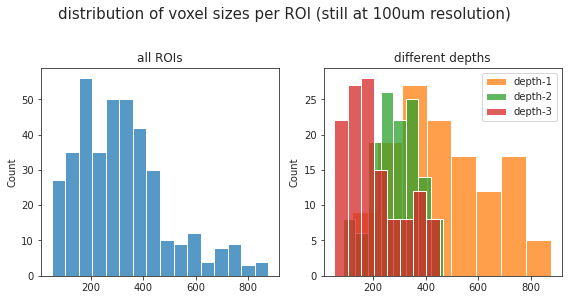

In [7]:
# HIDE CODE


cortex = mice.parcel['cortex']
regions = mice.parcel['regions-cortex']
hcl = mice.parcel.decode(regions)

sizes = collections.Counter(cortex[cortex.nonzero()])
sizes_np = np.array(list(sizes.values()))

fig, axes = create_figure(1, 2, (8, 4))
sns.histplot(sizes_np, ax=axes[0])
axes[0].set_title('all ROIs')

for ll in range(3):
    _sizes = mice.parcel.encode(hcl[hcl[:, -1] == ll])
    _sizes = cortex[np.isin(cortex, _sizes)]
    _sizes = collections.Counter(_sizes)
    _sizes_np = np.array(list(_sizes.values()))
    sns.histplot(_sizes_np, ax=axes[1], color=f"C{ll+1}", label=f"depth-{ll+1}")
axes[1].legend()
axes[1].set_title('different depths')

fig.suptitle('distribution of voxel sizes per ROI (still at 100um resolution)', fontsize=15, y=1.03)

plt.show()

## Visualize in individual spaces (at $200 \mu m$ resolution)

In [8]:
# HIDE CODE


mask_files = sorted([
    str(e) for e in
    pathlib.Path(mice.cfg.masks_dir).rglob('*_cortex.nii.gz*')
])

t1ws = {}
objs = {}
for key, anat in mice.T1w.items():
    file = next(
        f for f in mask_files
        if key in f
    )
    mask = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    )
    m = mice.mask3d[key].load_ants().numpy()
    objs[key], t1ws[key] = filter_boundaries(
        [mask.numpy(), anat.load_ants().numpy()], m)

### Coronal

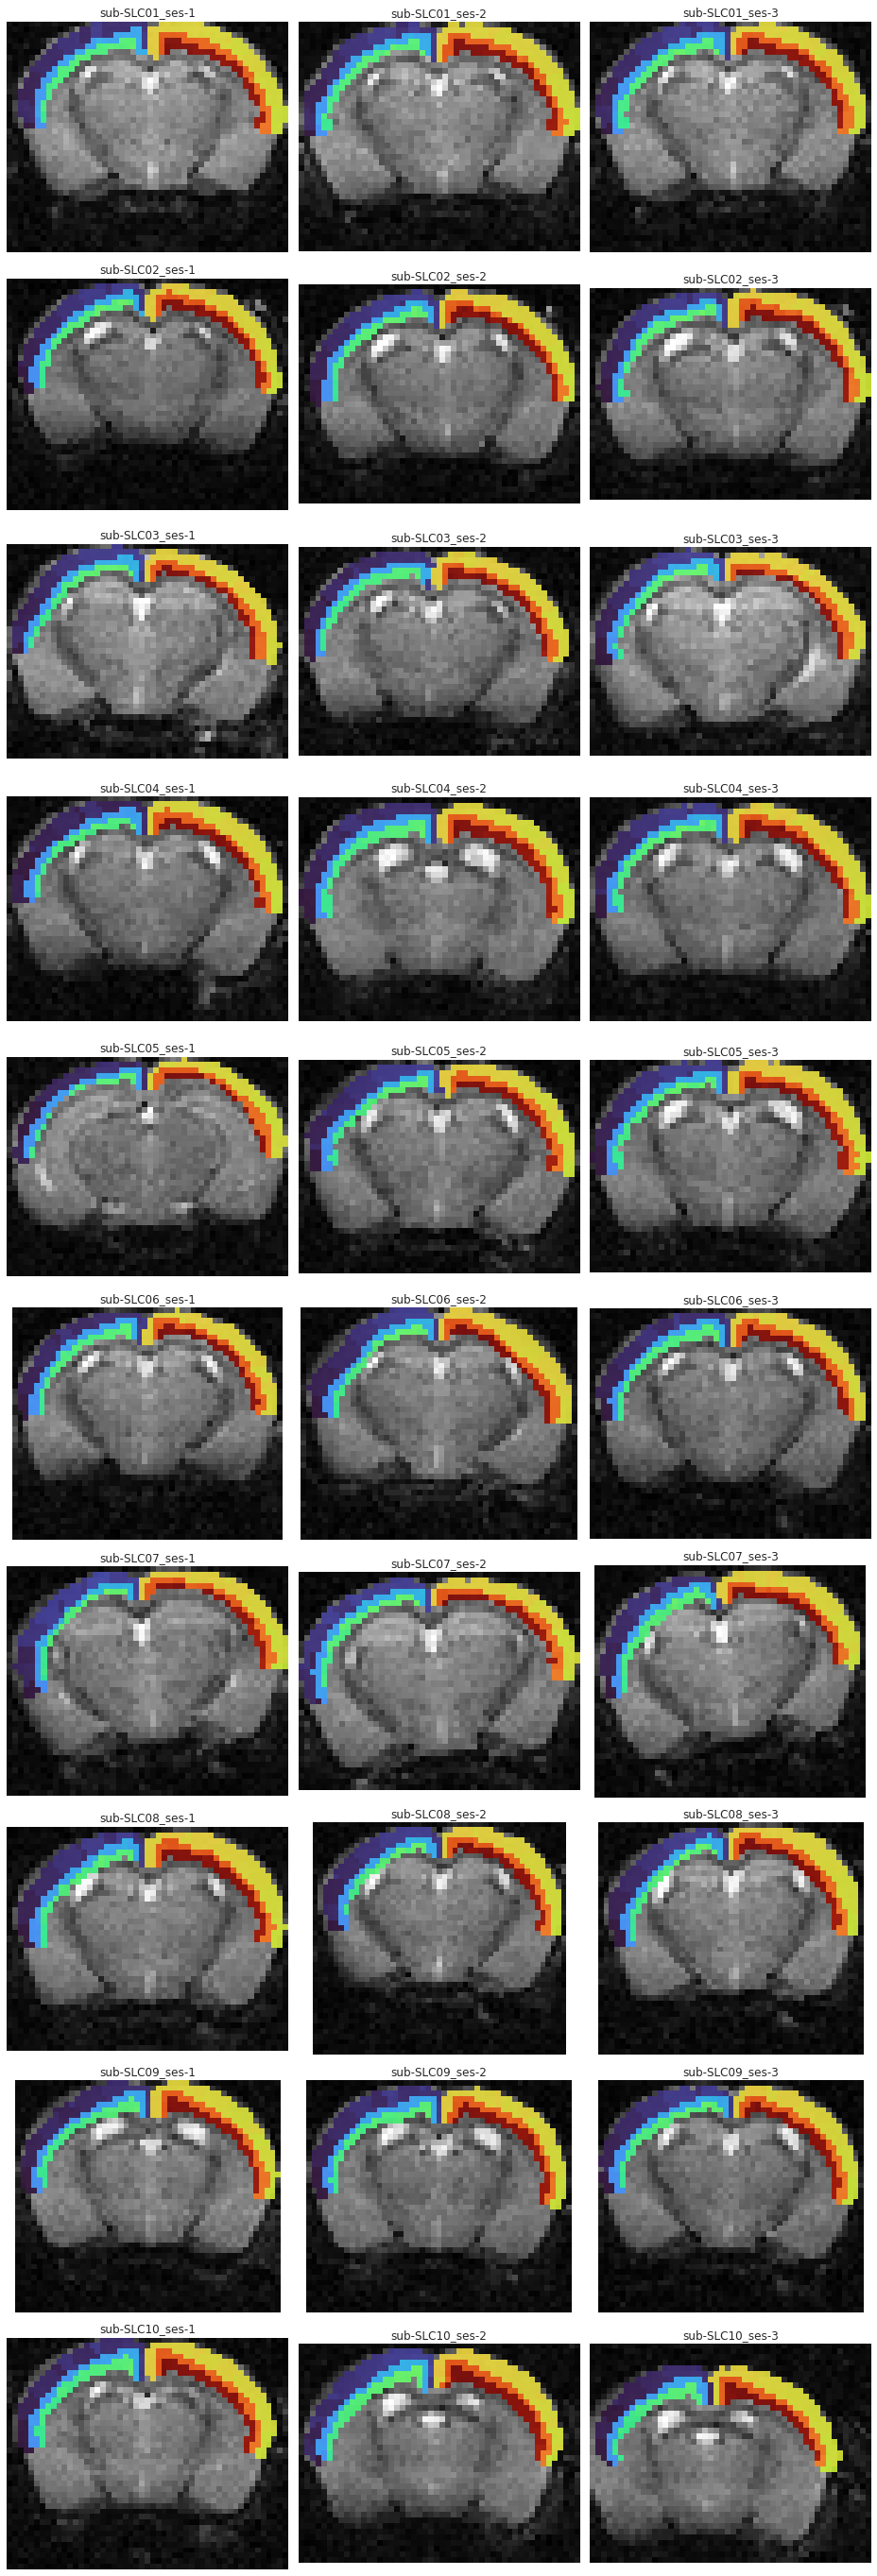

In [9]:
# HIDE CODE


fig, axes = create_figure(10, 3, (13, 38))
for ax, (key, obj) in zip(axes.flat, objs.items()):
    x2plt = np.ma.masked_where(~obj.astype(bool), obj)
    ax.imshow(t1ws[key][..., 40].T, cmap='Greys_r')
    ax.imshow(x2plt[..., 40].T, alpha=0.9, cmap='turbo')
    ax.set_title(key)
remove_ticks(axes)
plt.show()

### Sagittal

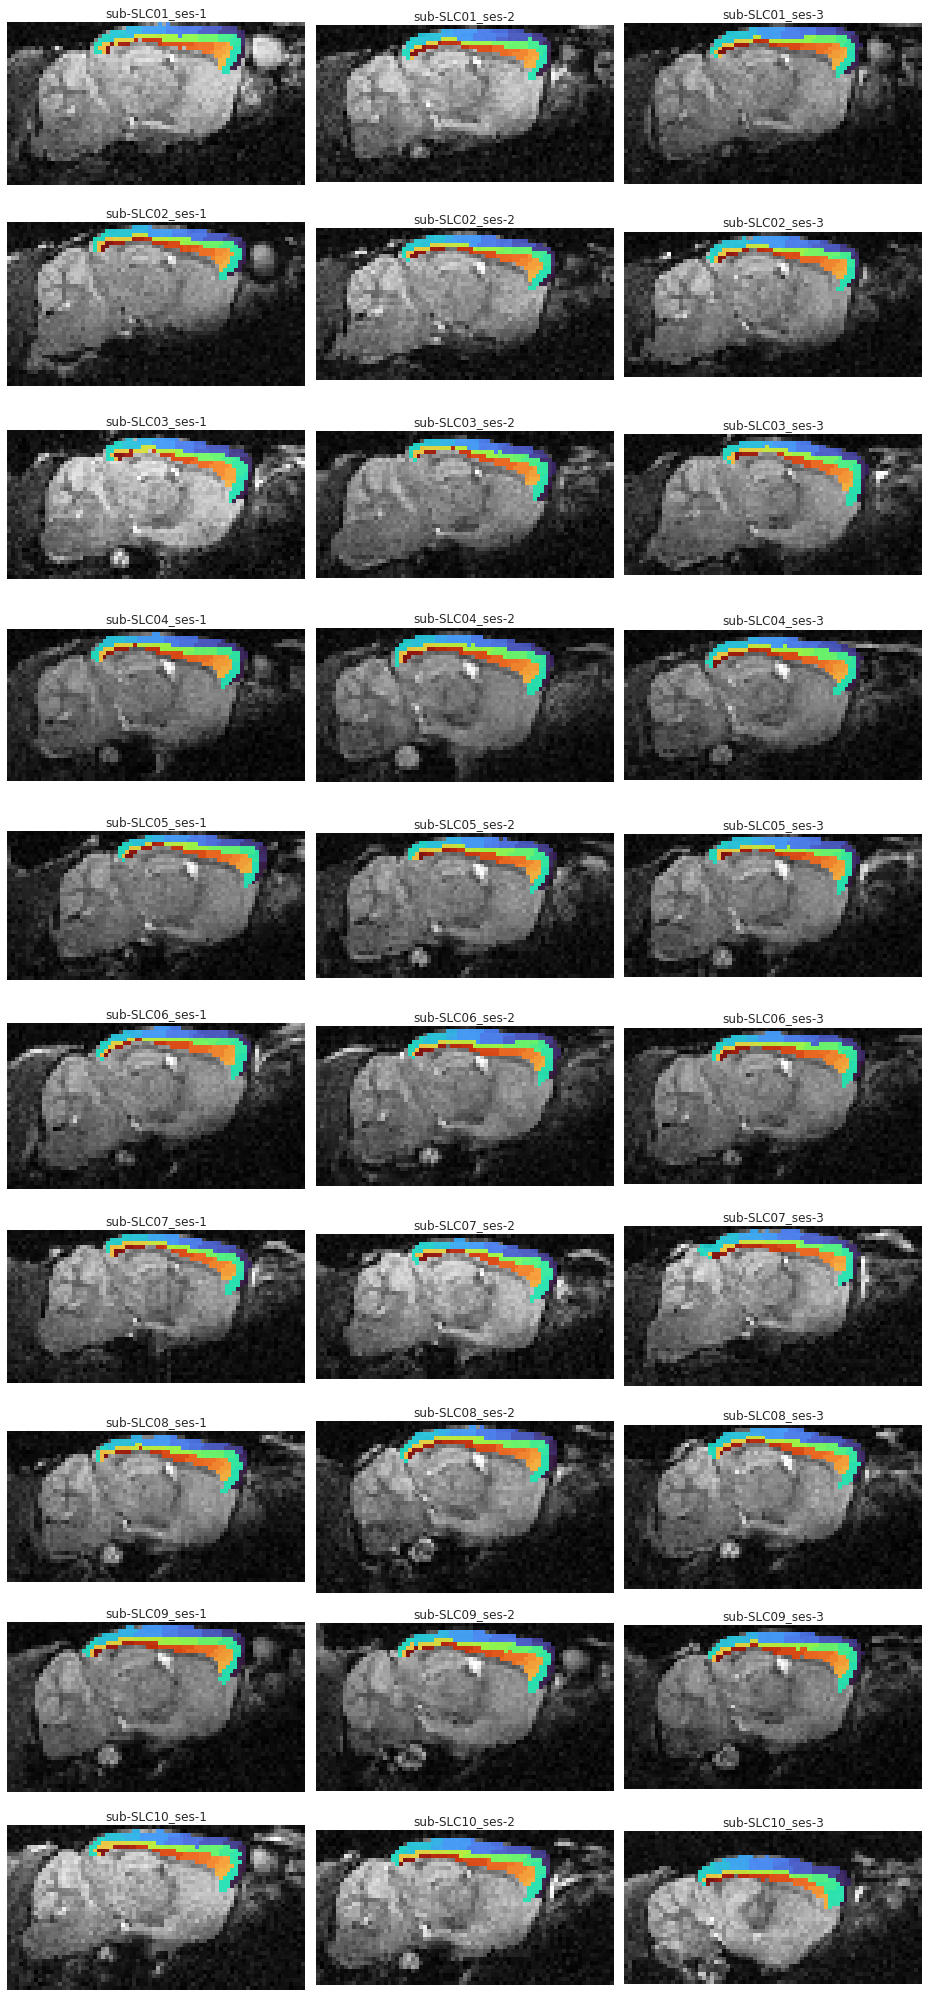

In [10]:
# HIDE CODE


fig, axes = create_figure(10, 3, (13, 28))
for ax, (key, obj) in zip(axes.flat, objs.items()):
    x2plt = np.ma.masked_where(~obj.astype(bool), obj)
    ax.imshow(t1ws[key][34], cmap='Greys_r')
    ax.imshow(x2plt[34], alpha=0.9, cmap='turbo')
    ax.set_title(key)
remove_ticks(axes)
plt.show()

### Axial

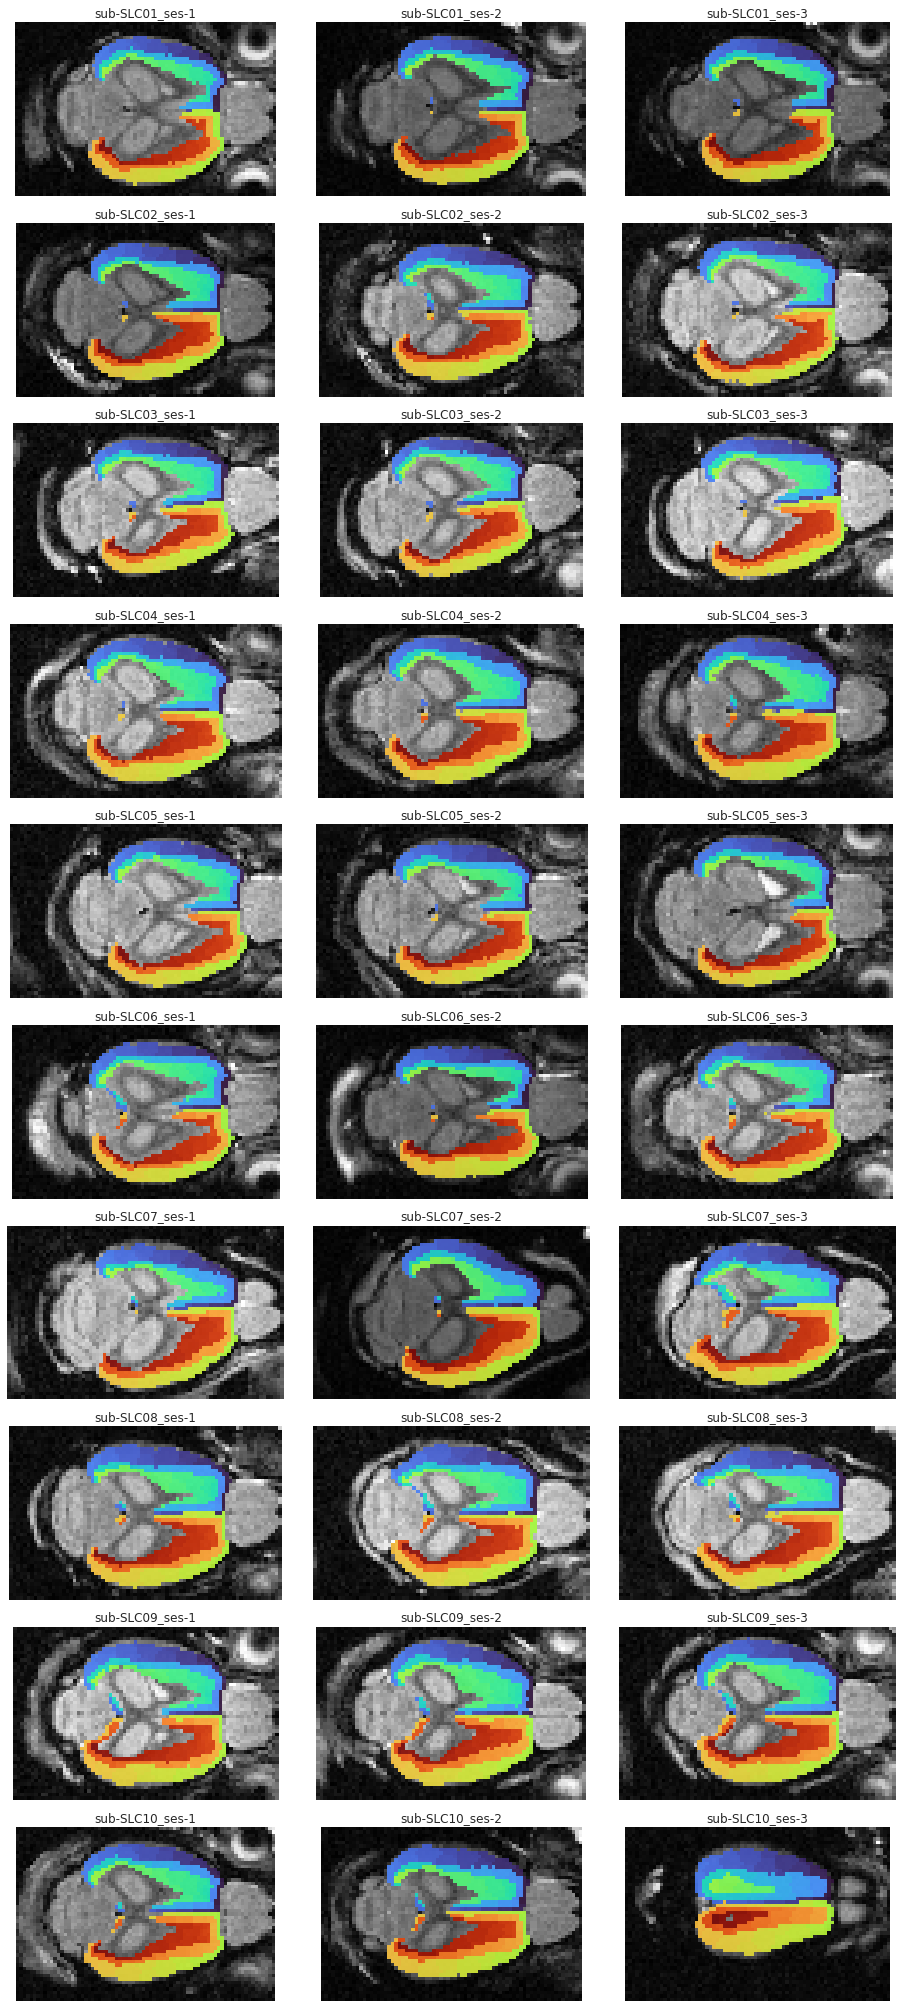

In [11]:
# HIDE CODE


fig, axes = create_figure(10, 3, (13, 28))
for ax, (key, obj) in zip(axes.flat, objs.items()):
    x2plt = np.ma.masked_where(~obj.astype(bool), obj)
    ax.imshow(t1ws[key][:, 7, :], cmap='Greys_r')
    ax.imshow(x2plt[:, 7, :], alpha=0.9, cmap='turbo')
    ax.set_title(key)
remove_ticks(axes)
plt.show()

### Distribution of ROI sizes (individual space)

In [12]:
# HIDE CODE


dlist = []
for key, obj in objs.items():
    for ll in range(3):
        _regions = mice.parcel.encode(hcl[hcl[:, -1] == ll])
        _sizes = obj[np.isin(obj, _regions)]
        _sizes = collections.Counter(_sizes)
        _sizes = {i: _sizes.get(i, 0) for i in _regions}
        dlist.append({
            'key': [key] * len(_sizes),
            'depth': [ll + 1] * len(_sizes),
            'region': _sizes.keys(),
            'vox': _sizes.values(),
        })
df_vox = pd.DataFrame(merge_dicts(dlist))

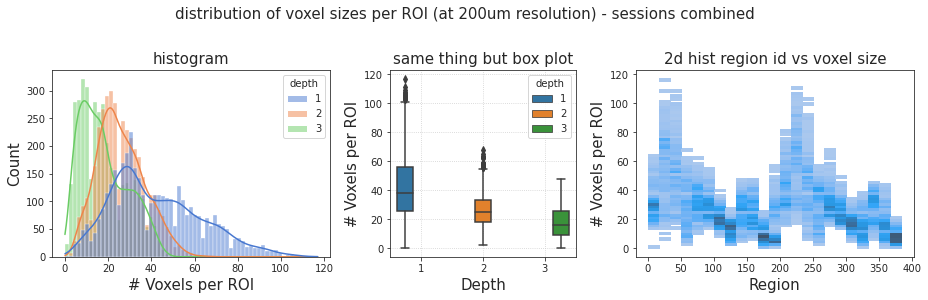

In [13]:
# HIDE CODE


fig, axes = create_figure(1, 3, (13, 4), gridspec_kw={'width_ratios': [1.5, 1, 1.5]})

sns.histplot(data=df_vox, x='vox', hue='depth', palette='muted', kde=True, ax=axes[0])
sns.boxplot(data=df_vox, x='depth', y='vox', hue='depth', ax=axes[1])
sns.histplot(data=df_vox, y='vox', x='region', ax=axes[2])
axes[0].set_xlabel('# Voxels per ROI', fontsize=15)
axes[1].set_ylabel('# Voxels per ROI', fontsize=15)
axes[2].set_ylabel('# Voxels per ROI', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Depth', fontsize=15)
axes[2].set_xlabel('Region', fontsize=15)
axes[0].set_title('histogram', fontsize=15)
axes[1].set_title('same thing but box plot', fontsize=15)
axes[2].set_title('2d hist region id vs voxel size', fontsize=15)
axes[1].grid()
fig.suptitle(
    'distribution of voxel sizes per ROI (at 200um resolution) - sessions combined', fontsize=15, y=1.03)
plt.show()

In [14]:
df_vox.loc[df_vox['vox'] < 2]

,key,depth,region,vox
13,sub-SLC01_ses-1,1,14,0
308,sub-SLC01_ses-1,3,181,1
365,sub-SLC01_ses-1,3,366,0
372,sub-SLC01_ses-1,3,373,1
1092,sub-SLC01_ses-3,3,325,1
1453,sub-SLC02_ses-1,3,174,1
1524,sub-SLC02_ses-1,3,373,1
2228,sub-SLC02_ses-3,3,181,1
2996,sub-SLC03_ses-2,3,181,1
3067,sub-SLC03_ses-2,3,380,1


In [15]:
sorted(collections.Counter(df_vox['vox']).most_common())[:10]

[
    (0, 3),
    (1, 21),
    (2, 51),
    (3, 88),
    (4, 155),
    (5, 177),
    (6, 175),
    (7, 205),
    (8, 251),
    (9, 210)
]

## Render

Here I've embedded an interactive 3D rendering of ROIs.

In [16]:
width=800
height=700

### Full ROIs (columns and layers)

In [17]:
file = f"../../_extras/columnar_n64*0_k384.html"
IFrame(file, width=width, height=height)

### Columns only (right hemisphere)

In [18]:
file = f"../../_extras/columns_n64*0_k64.html"
IFrame(file, width=width, height=height)

### Layers only (3 depths)

In [19]:
file = f"../../_extras/layers_n64*0_k3.html"
IFrame(file, width=width, height=height)

## Transform masks (ignore)

In [2]:
from register.register import Register

mice = Mice((64, 0, 100), load_parcel=True, load_allen=True)
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
reg.register_anat(True)

registering anat sub-SLC10_ses-3: 100%|██████████| 30/30 [11:27<00:00, 22.93s/it]
